<a href="https://colab.research.google.com/github/SylwiaNowakowska/Convolutional_Neural_Networks_Ophthalmology/blob/master/01_HIV_Dataset_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Neural Networks for Drug Discovery

This project is inspired by DeepFindr GNN project: <br>
https://www.youtube.com/@DeepFindr/videos <br>
https://github.com/deepfindr/gnn-project

### PyTorch Geometric and RDKit installation 

In [ ]:
!python --version

Python 3.7.15


In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.12.1+cu113
     |████████████████████████████████| 8.9 MB 2.6 MB/s 
     |████████████████████████████████| 3.5 MB 3.1 MB/s 
     |████████████████████████████████| 280 kB 5.0 MB/s 


In [ ]:
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 29.1 MB 1.8 MB/s 


In [ ]:
print(f"Torch version: {torch.__version__}")
print(f"Cuda available: {torch.cuda.is_available()}")
print(f"Torch geometric version: {torch_geometric.__version__}")

Torch version: 1.12.1+cu113
Cuda available: False
Torch geometric version: 2.2.0


### Imports

In [ ]:
import torch
import torch_geometric
from torch_geometric.datasets import MoleculeNet

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

### Dataset Download / Loading

In [ ]:
dataset_path = '/content/drive/MyDrive/COLAB_NOTEBOOKS/Graph_Neural_Network_Drug_Discovery_HIV_Dataset'

In [ ]:
### Downloading the dataset with automatic creation of PyTorch Geometric in memory dataset
## The following line downloads and process the data - need to be run only once
#data = MoleculeNet(root=dataset_path, name='HIV')

## Afterwards, the dataset can be loaded from the drive
#data_path = os.path.join(dataset_path, 'hiv/processed/data.pt')
#data = torch.load(data_path)

In [ ]:
# HIV CSV file
csv_path = os.path.join(dataset_path, 'hiv/raw/HIV.csv')
dataset_df = pd.read_csv(csv_path)
display(dataset_df.head())

,smiles,activity,HIV_active
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0


### Dataset EDA

In [ ]:
print(f'There are {dataset_df.shape[0]} molecules in the dataset.')

There are 41127 molecules in the dataset.


In [ ]:
def plot_classes_distribution(df, class_column, figure_title=None, figsize=(6, 3)):

    plt.rcParams.update({'font.size': 14})
    fig, axs = plt.subplots(1,1, figsize=figsize)
    
    if figure_title:
        fig.suptitle(figure_title, fontsize=16, y = 1, x = 0.52)
        
    df_value_counts = df[class_column].value_counts().sort_index()
    axs.bar(df_value_counts.index, df_value_counts, alpha=0.7) 
    axs.xaxis.set_major_locator(MaxNLocator(integer=True))    
    plt.show()
    
    return df_value_counts

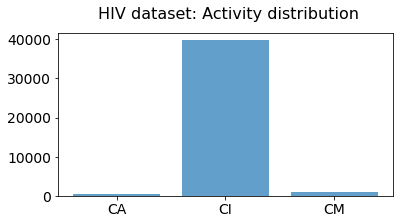

CA      404
CI    39684
CM     1039
Name: activity, dtype: int64

In [ ]:
activity_value_counts = plot_classes_distribution(dataset_df, class_column='activity', 
                          figure_title='HIV dataset: Activity distribution')
activity_value_counts

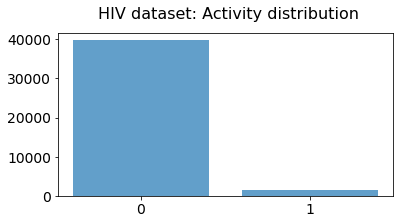

0    39684
1     1443
Name: HIV_active, dtype: int64

In [ ]:
HIV_activity_value_counts = plot_classes_distribution(dataset_df, class_column='HIV_active', 
                          figure_title='HIV dataset: Activity distribution')
HIV_activity_value_counts

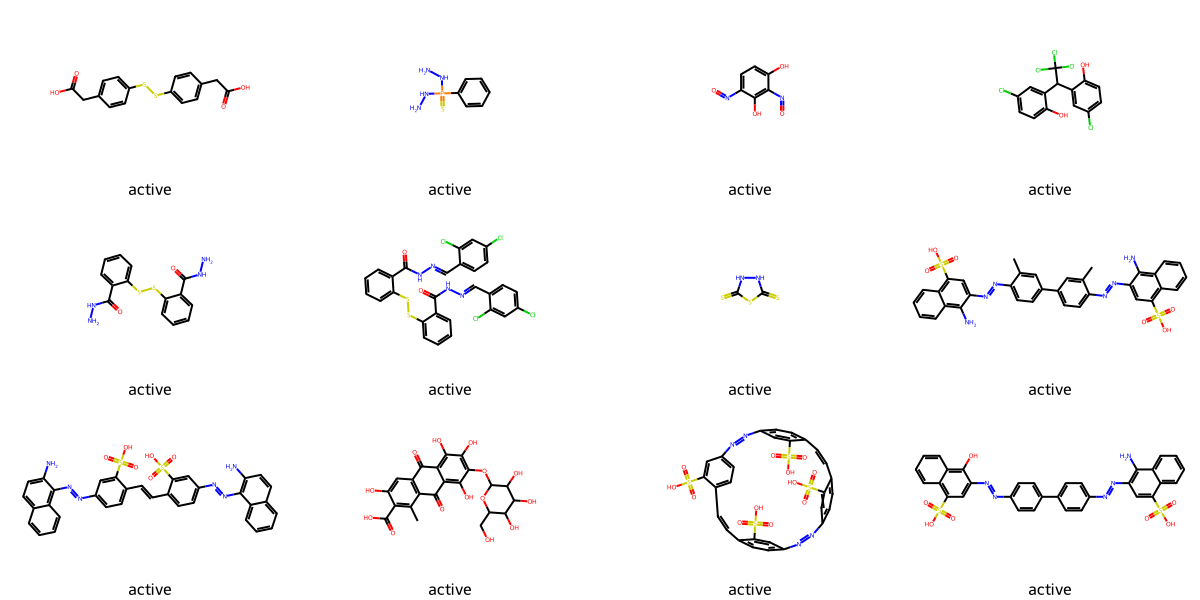

In [ ]:
dataset_active_df = dataset_df[dataset_df['HIV_active'] == 1]
dataset_inactive_df = dataset_df[dataset_df['HIV_active'] == 0]

sample_mols = 12

active_molecules_smiles = dataset_active_df['smiles'][0:sample_mols].values
active_molecules_labels = dataset_active_df['HIV_active'][0:sample_mols].values
active_molecules = [Chem.MolFromSmiles(smiles) for smiles in active_molecules_smiles]
active_labels = ["active"] * sample_mols
active_molecules_grid = Draw.MolsToGridImage(active_molecules, molsPerRow=4, 
                                              subImgSize=(300,200), legends=active_labels)
active_molecules_grid

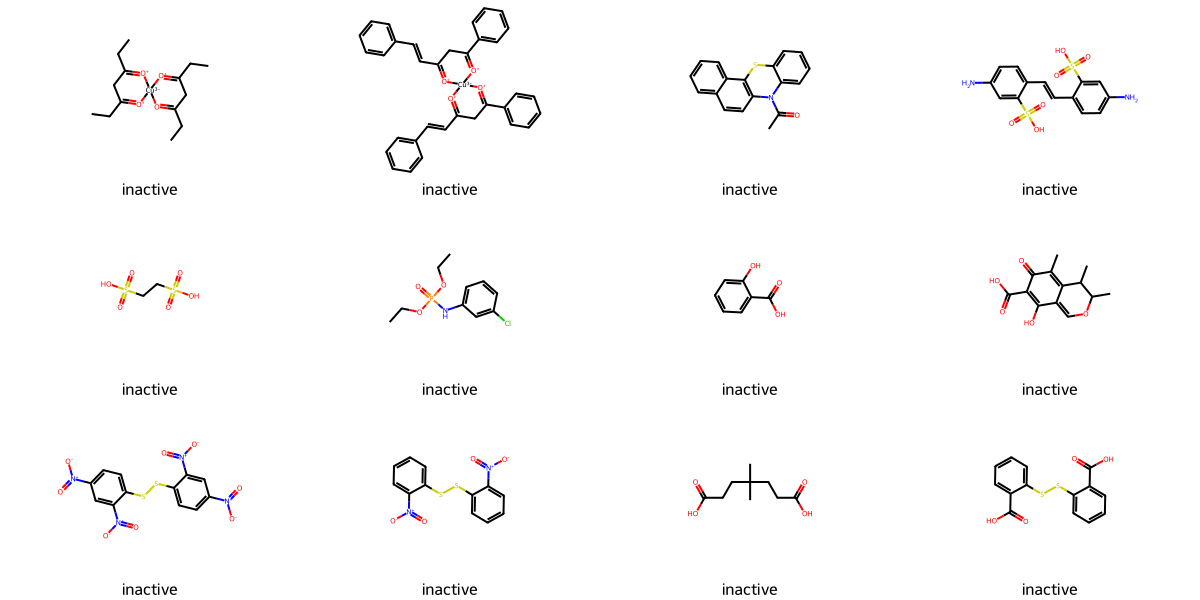

In [ ]:
inactive_molecules_smiles = dataset_inactive_df['smiles'][0:sample_mols].values
inactive_molecules_labels = dataset_inactive_df['HIV_active'][0:sample_mols].values
inactive_molecules = [Chem.MolFromSmiles(smiles) for smiles in inactive_molecules_smiles]
inactive_labels = ["inactive"] * sample_mols
inactive_molecules_grid = Draw.MolsToGridImage(inactive_molecules, molsPerRow=4, 
                                              subImgSize=(300,200), legends=inactive_labels)
inactive_molecules_grid

In [ ]:
print(type(data[0]))
print(data[0])

print(type(data[1]))
print(data[1])

<class 'torch_geometric.data.data.Data'>
Data(x=[1049163, 9], edge_index=[2, 2259376], edge_attr=[2259376, 3], smiles=[41127], y=[41127, 1])
<class 'collections.defaultdict'>
defaultdict(<class 'dict'>, {'x': tensor([      0,      19,      58,  ..., 1049093, 1049126, 1049163]), 'edge_index': tensor([      0,      40,     128,  ..., 2259220, 2259296, 2259376]), 'edge_attr': tensor([      0,      40,     128,  ..., 2259220, 2259296, 2259376]), 'smiles': tensor([    0,     1,     2,  ..., 41125, 41126, 41127]), 'y': tensor([    0,     1,     2,  ..., 41125, 41126, 41127])})
